In [102]:
import numpy as np
import geopandas as gpd
import pandas as pd
import shapely as sh
import matplotlib.pyplot as plt
import time
import math
import sys
import os
import rasterio
import shapely

In [103]:
data = gpd.read_file("data/mtbs_perimeter_data/mtbs_perims_DD.shp")
conus = gpd.read_file("data/conus_extracted.shp")

In [104]:
print(data.columns)
print(data["Ig_Date"])
print(type(data["Ig_Date"][0]))
print(type(data["geometry"][0]))

print(conus)


Index(['Event_ID', 'irwinID', 'Incid_Name', 'Incid_Type', 'Map_ID', 'Map_Prog',
       'Asmnt_Type', 'BurnBndAc', 'BurnBndLat', 'BurnBndLon', 'Ig_Date',
       'Pre_ID', 'Post_ID', 'Perim_ID', 'dNBR_offst', 'dNBR_stdDv', 'NoData_T',
       'IncGreen_T', 'Low_T', 'Mod_T', 'High_T', 'Comment', 'geometry'],
      dtype='object')
0       1985-08-01
1       1985-07-20
2       1985-08-01
3       1985-08-03
4       1985-03-02
           ...    
30027   2024-03-10
30028   2024-03-28
30029   2024-02-08
30030   2024-02-28
30031   2024-04-05
Name: Ig_Date, Length: 30032, dtype: datetime64[ms]
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'shapely.geometry.polygon.Polygon'>
  STATEFP   STATENS     AFFGEOID GEOID STUSPS         NAME LSAD         ALAND  \
0      28  01779790  0400000US28    28     MS  Mississippi   00  121533519481   

       AWATER                                           geometry  
0  3926919758  MULTIPOLYGON (((-80.73124 24.86521, -80.7293 2...  


In [105]:
### get subset of fires that have occured since Jan 1 2018... we can move this up to the GOES-East launch date at some point
recent_fires = data[data['Ig_Date'] >= pd.Timestamp('2018-01-01')]

In [106]:
print(recent_fires.shape[0], "have occured since the cutoff date out of", data.shape[0])
### reproject recent fires to albers conical (?) so we can compute fire size in meters
recent_fires = recent_fires.to_crs(epsg=5070)
conus = conus.to_crs(epsg=5070)

5262 have occured since the cutoff date out of 30032


SyntaxError: invalid syntax. Perhaps you forgot a comma? (2417299775.py, line 1)

In [ ]:
conus.iloc[0]["geoms"] = conus.iloc[0]["geoms"].geoms[0]

In [107]:
clipped_gdf = recent_fires.clip(mask=conus)
print("trimmed file to conus")

trimmed file to conus


In [108]:
### extract fire areas, bounding_boxes from data
fire_size = np.zeros(recent_fires.shape[0])
### [xmax, y_min, x_min, y_max]
fire_bbox = np.zeros((recent_fires.shape[0], 4))
ig_day = np.zeros(recent_fires.shape[0])
ig_data = []
for i in range(len(recent_fires)):
    fire_size[i] = recent_fires.iloc[i]["geometry"].area
    fire_bbox[i] = recent_fires.iloc[i]["geometry"].bounds
    ig_day[i] = recent_fires.iloc[i]["Ig_Date"].dayofyear
    ig_data.append(recent_fires.iloc[i]["Ig_Date"])
### sanity check on fire bounding box extraction
print(fire_bbox[1], recent_fires.iloc[1]["geometry"].bounds)

[1545136.98461606  385078.5988474  1550862.0468887   389699.07188802] (1545136.9846160552, 385078.5988474029, 1550862.0468886993, 389699.0718880221)


total burned area in subset 172930584650.0279 m^2
largest fire in subset 4325251517.138804 m^2


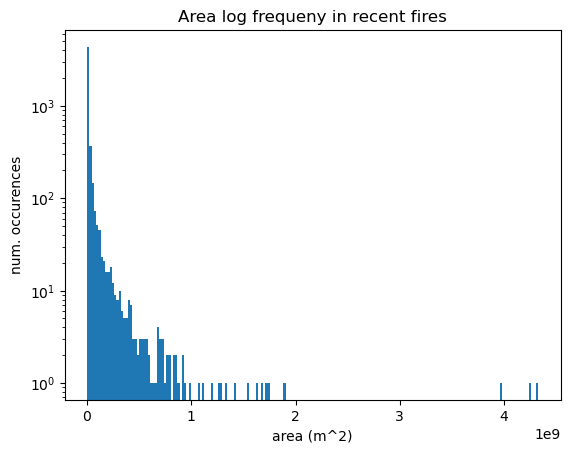

In [109]:
plt.hist(fire_size, bins=200)
plt.yscale('log')
plt.title("Area log frequeny in recent fires")

plt.xlabel("area (m^2)")
plt.ylabel("num. occurences")

print("total burned area in subset", np.sum(fire_size), "m^2")
print("largest fire in subset", np.max(fire_size), "m^2")

In [110]:
def convert_bbox(i, xy, buffer=0):
    ### [xmax, y_min, x_min, y_max] ???
    if xy == "x":
        return [i[2]+buffer, i[2]+buffer, i[0]-buffer, i[0]-buffer, i[2]+buffer]
    else:
        return[i[1]-buffer, i[3]+buffer, i[3]+buffer, i[1]-buffer, i[1]-buffer]

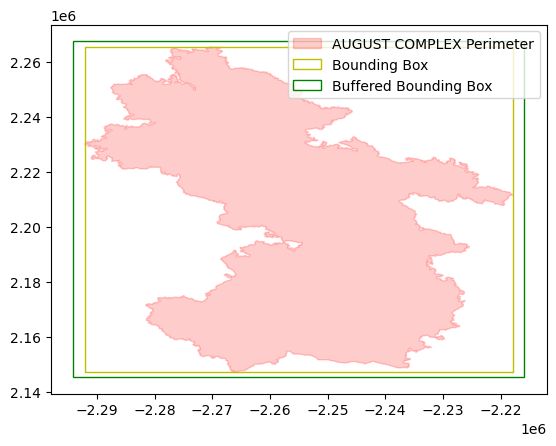

In [111]:
fig, axs = plt.subplots()
xsi, ysi = recent_fires.iloc[np.argmax(fire_size)]["geometry"].exterior.xy   
axs.fill(xsi, ysi, alpha=0.2, fc='r', ec='r', label=recent_fires.iloc[np.argmax(fire_size)]["Incid_Name"] + " Perimeter")
axs.fill(convert_bbox(fire_bbox[np.argmax(fire_size)], "x"),convert_bbox(fire_bbox[np.argmax(fire_size)], "y"), fc="none", ec='y', label="Bounding Box")
axs.fill(convert_bbox(fire_bbox[np.argmax(fire_size)], "x", 2000),convert_bbox(fire_bbox[np.argmax(fire_size)], "y", 2000), fc="none", ec='g', label="Buffered Bounding Box")

axs.legend()

In [112]:
print(recent_fires.iloc[np.argmax(fire_size)])
### 264222

Event_ID                                  CA3966012280920200817
irwinID                    EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA
Incid_Name                                       AUGUST COMPLEX
Incid_Type                                             Wildfire
Map_ID                                                 10021108
Map_Prog                                                   MTBS
Asmnt_Type                                             Extended
BurnBndAc                                               1068802
BurnBndLat                                                39.94
BurnBndLon                                              -123.03
Ig_Date                                     2020-08-17 00:00:00
Pre_ID                                          804503220200715
Post_ID                                         804503220210718
Perim_ID                                        804503220201019
dNBR_offst                                                   37
dNBR_stdDv                              

In [113]:
### look for instances that have an area greater than 1 GOES pixel (2km * 2km)
spatial_res = 2000
plus_pix = np.argwhere(fire_size > (spatial_res ** 2))

4247


Text(0, 0.5, 'num. occurences')

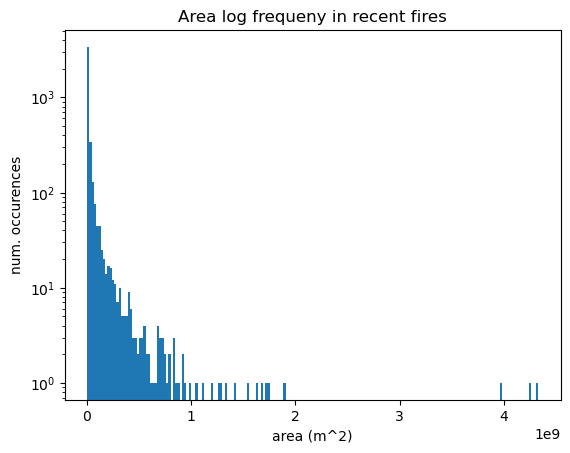

In [114]:
print(len(plus_pix))
plt.hist(fire_size[plus_pix], bins=200)
plt.yscale('log')
plt.title("Area log frequeny in recent fires")

plt.xlabel("area (m^2)")
plt.ylabel("num. occurences")

#print("total burned area in subset", np.sum(fire_size), "m^2")
#print("largest fire in subset", np.max(fire_size), "m^2")

In [115]:
print(type(recent_fires.iloc[10]["Ig_Date"]))
print(recent_fires.iloc[10]["Ig_Date"].month)
print(recent_fires.iloc[10]["Ig_Date"].day)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
4
26


Text(0.5, 1.0, 'Severity of Fires over Calendar Year')

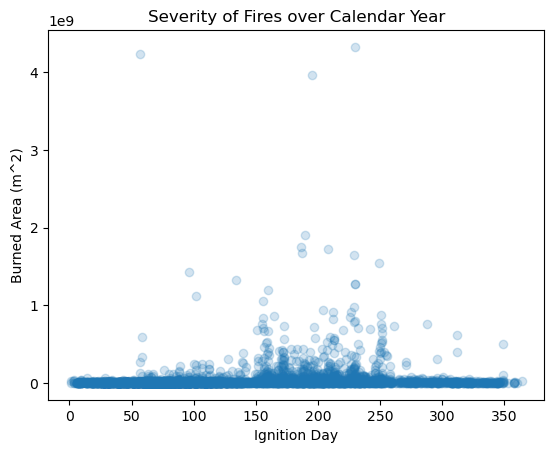

In [ ]:
# ig_data
plt.scatter(ig_day, fire_size, alpha=0.2, color="mauve")
plt.xlabel("Ignition Day")
plt.ylabel("Burned Area (m^2)")
plt.title("Severity of Fires over Calendar Year")

Text(0.5, 1.0, 'Frequency of Ignitions over Calendar Year')

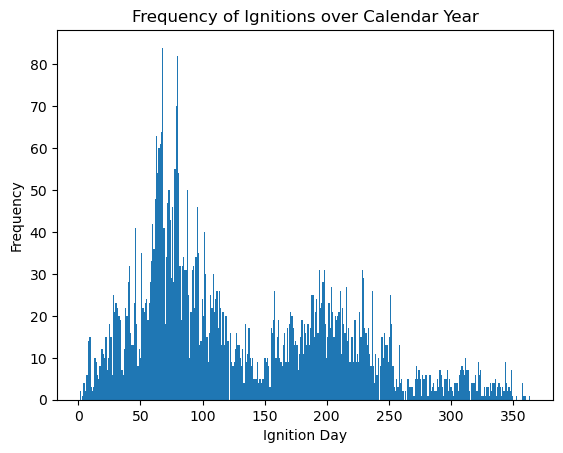

In [126]:
plt.hist(ig_day, bins=366)
plt.xlabel("Ignition Day")
plt.ylabel("Frequency")
plt.title("Frequency of Ignitions over Calendar Year")

In [ ]:
### need to be able to get fire duration! from there we can export shapefiles and scrape from Google Earth Engine
gfd = []
start_year = 18
end_year = 24
for i in range(start_year, end_year):
    gfd.append(gpd.read_file("data/GLOBFIRE_burned_area_full_dataset_2002_2023/original_globfire_filtered_20" + str(i) + ".shp"))
    gfd[-1] = gfd[-1].to_crs(epsg=5070).clip(mask=conus)
    #gfd[-1] = gfd[-1]
    print("trimmed file", i, "to conus")

GEOSException: TopologyException: side location conflict at -2270688.3024068531 2134900.376998628. This can occur if the input geometry is invalid.

In [85]:
print(gfd[2].iloc[0])

_uid_                                                       1.0
id                                                   23349566.0
initialdat                                  2020-07-24 00:00:00
finaldate                                   2020-07-28 00:00:00
area_ha                                               64.242735
geometry      POLYGON ((4598561.660963886 -3584082.489568353...
Name: 0, dtype: object


In [86]:
### year is i + 18
temp_2020 = gfd[2]["initialdat"].to_numpy()

In [90]:
#2020-08-17
august = np.argwhere(temp_2020 == np.datetime64('2020-08-12T00:00:00.000'))

In [91]:
"""print(len(august[0]), len(temp_2020))
print(august)
where_big = []
bigness = []
for i in range(len(august[0])):
    where_big.append(gfd[2].iloc[august[0][i]]['area_ha'])
"""
where_big = gfd[2]["area_ha"].to_numpy()[august]
print(np.max(where_big))
print(np.argmax(where_big))


309187.69598630245
3148


_uid_                                                    3149.0
id                                                   23354161.0
initialdat                                  2020-07-22 00:00:00
finaldate                                   2020-07-27 00:00:00
area_ha                                              107.152269
geometry      MULTIPOLYGON (((4611659.724366912 -3905347.041...
Name: 3148, dtype: object
n_perims: 2
264199
n_perims: 48


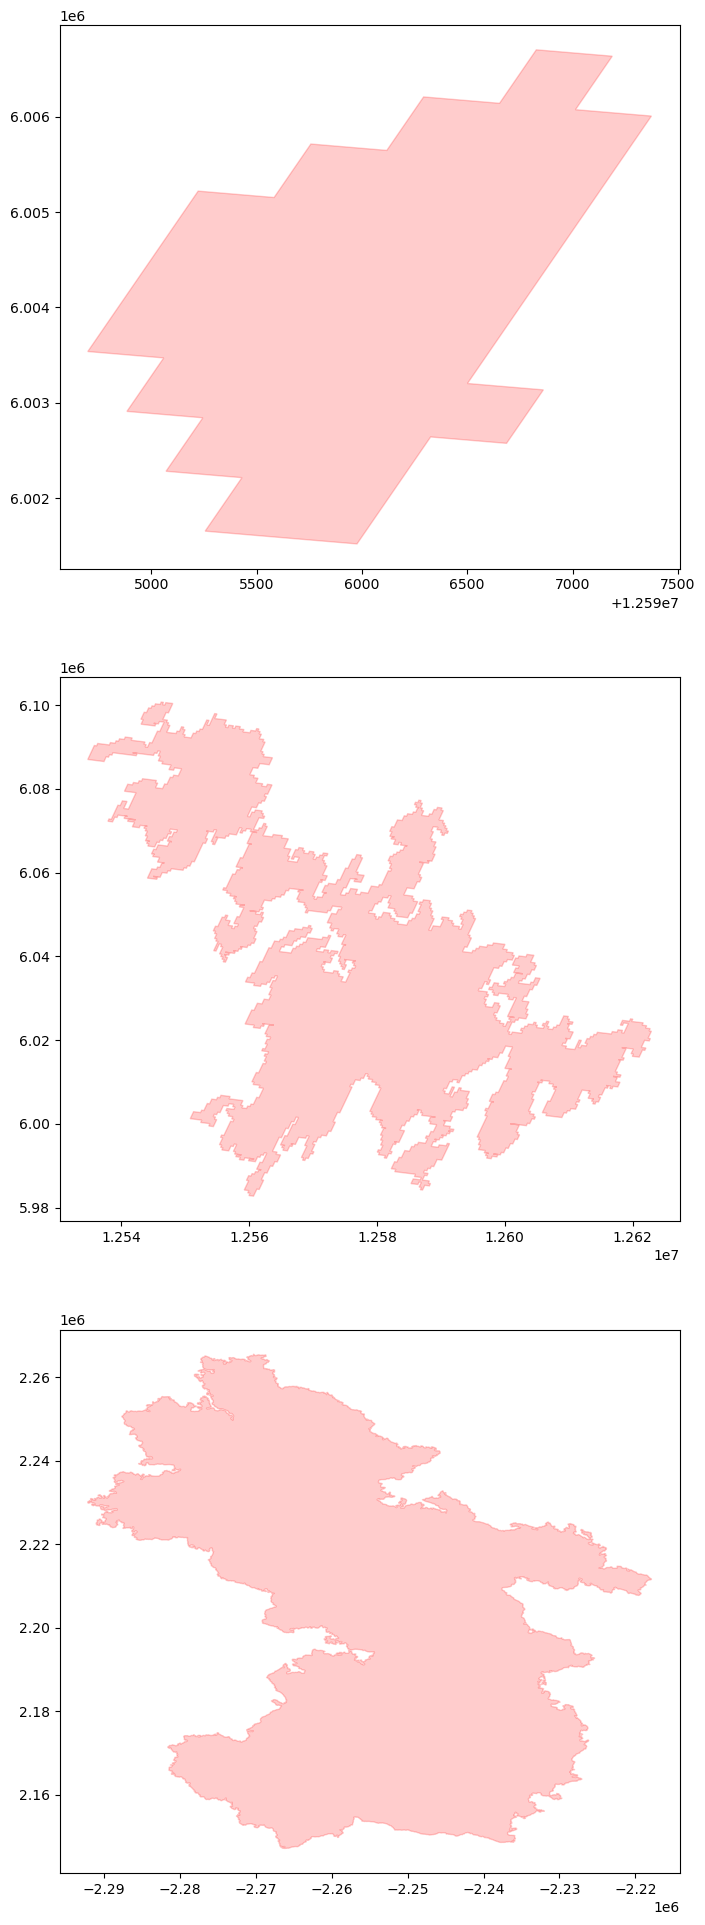

In [95]:
### get perim from...
figs, axs = plt.subplots(3, 1, figsize=(8, 24))
print(gfd[2].iloc[np.argmax(where_big)])
print("n_perims:", len(gfd[2].iloc[np.argmax(where_big)]["geometry"].geoms))
print(august[np.argmax(where_big)][0])
print("n_perims:", len(gfd[2].iloc[august[np.argmax(where_big)][0]]["geometry"].geoms))
for zz in [1]:#range(len(gfd[2].iloc[np.argmax(where_big)]["geometry"].geoms)):
    sanity_xi, sanity_yi = gfd[2].iloc[august[np.argmax(where_big)][0]]["geometry"].geoms[zz].exterior.xy
    axs[0].fill(sanity_xi, sanity_yi, alpha=0.2, fc='r', ec='r', label=recent_fires.iloc[np.argmax(fire_size)]["Incid_Name"] + " Perimeter")
sanity_x, sanity_y = gfd[2].iloc[august[np.argmax(where_big)][0]]["geometry"].geoms[0].exterior.xy
axs[1].fill(sanity_x, sanity_y, alpha=0.2, fc='r', ec='r', label=recent_fires.iloc[np.argmax(fire_size)]["Incid_Name"] + " Perimeter")
xsi, ysi = recent_fires.iloc[np.argmax(fire_size)]["geometry"].exterior.xy   
axs[2].fill(xsi, ysi, alpha=0.2, fc='r', ec='r', label=recent_fires.iloc[np.argmax(fire_size)]["Incid_Name"] + " Perimeter")